# Подключим все необходимые библиотеки
Так как вся основная работа происходит в Google colab, то некотрые библиотеки могут быть не подгружены

In [2]:
!pip install surprise

In [34]:
!pip install matplotlib==3.1.3
!pip install implicit 

     |████████████████████████████████| 13.1 MB 4.8 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 18.5 MB 443 kB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/VK_test

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/VK_test


Подключим самые нужные библиотеки, так сказать, ЭТО БАЗА 

In [4]:
import numpy as np
import pandas as pd

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# установим фиксированный размер наших графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [ ]:
# для того, чтобы не засорять вывод предупреждениями
import warnings
warnings.filterwarnings('ignore')

Дальше пойдут сюрпризы

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from surprise import Reader, Dataset, KNNBasic
from surprise.model_selection import cross_validate
from surprise import SVD
from surprise.prediction_algorithms.baseline_only import BaselineOnly
from surprise.prediction_algorithms.co_clustering import CoClustering

# Подгрузим необходимые датасеты и посмотрим на данные 
Будем проверять алгоритмы на small датасете, а финальные тесты будем проводить на large датасете. Нужно ещё убедиться корреллируют ли данные на двух датасетах (конечно они будут коррелировать, но проверить лишний раз нужно)

In [39]:
data_large = pd.read_csv('rating.csv')

In [ ]:
data_small = pd.read_csv('Mini_dataset/ratings.csv')

In [40]:
data_large['timestamp'] = pd.to_datetime(data_large['timestamp'], format=None)
data_large['ts'] = data_large.timestamp.values.astype(np.int64) // 10 ** 9
data_large = data_large.drop(columns='timestamp')
data_large.rename(columns = {'ts' : 'timestamp'}, inplace = True) 

In [ ]:
print(data_small.head())
print(data_large.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   userId  movieId  rating   timestamp
0       1        2     3.5  1112486027
1       1       29     3.5  1112484676
2       1       32     3.5  1112484819
3       1       47     3.5  1112484727
4       1       50     3.5  1112484580


In [ ]:
print(data_small.info())
print(data_large.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 610.4 MB
None


Убедимся, что small и large датасеты кореллируют между собой 

In [ ]:
data_large['rating'].describe()

count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [ ]:
data_small['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

[Text(0.5, 0, 'large_dataset')]

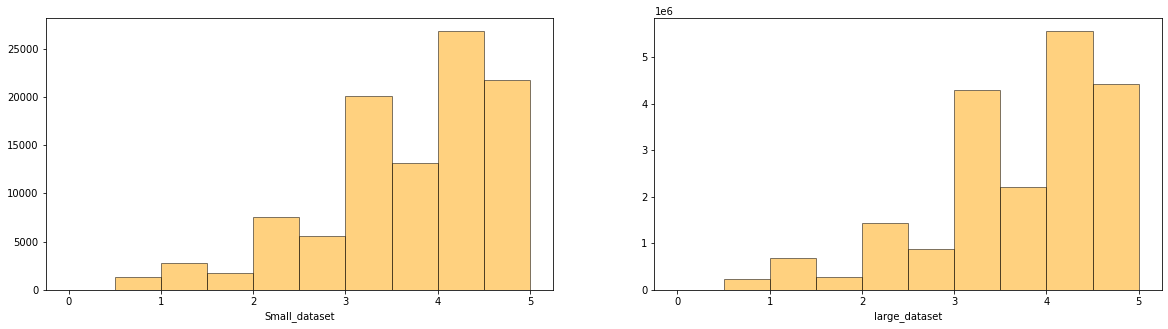

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 5))

axes[0].hist(data_small['rating'], range=(0, 5), bins=10, alpha=0.5, color="orange", edgecolor='black')
axes[0].set(xlabel = 'Small_dataset')
axes[1].hist(data_large['rating'], range=(0, 5), bins=10, alpha=0.5, color="orange", edgecolor='black')
axes[1].set(xlabel = 'large_dataset')

# Препроцессинг данных

Посмотрим на long_tail графики

     movieId  volume  cumulative_volume  percent_of_total_volume
1944    2739      12              77678                 0.770340
1945     125      12              77690                 0.770459
1946    2672      12              77702                 0.770578


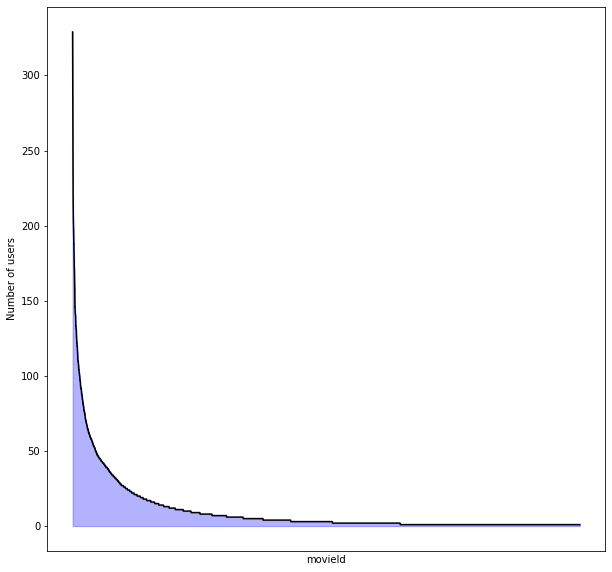

In [ ]:
df = data_small.copy()
item_id_column='movieId'
volume_df = df[item_id_column].value_counts().reset_index()
volume_df.columns = [item_id_column, "volume"]
volume_df[item_id_column] = volume_df[item_id_column].astype(str)
volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()
print(volume_df.iloc[int(len(volume_df)*0.2):int(len(volume_df)*0.2)+3, :])
x=range(0,len(volume_df))
ax = sns.lineplot(x, y='volume', data=volume_df, color="black")
ax.set_ylabel('Number of users')
ax.set_xlabel(item_id_column)
x1 = volume_df[item_id_column]
y1 = volume_df['volume']
ax.fill_between(x1, y1, color="blue", alpha=0.3)
plt.xticks([], [])
ax.set(xticklabels=[])
plt.show()

Если мы исключим 80% фильмов из выборки, у которых оценок меньше чем 12, то примерно 77% данных о взаимодействиях у нас останется, но зато мы получим более сильную модель

In [ ]:
data_small = data_small[~data_small['movieId'].isin(set(volume_df[volume_df['volume' ] < 12]['movieId'].astype(int)))]

In [41]:
df = data_large.copy()
item_id_column='movieId'
volume_df = df[item_id_column].value_counts().reset_index()
volume_df.columns = [item_id_column, "volume"]
volume_df[item_id_column] = volume_df[item_id_column].astype(str)
volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()

     movieId  volume  cumulative_volume  percent_of_total_volume
2674    8860    1306           17211678                 0.860573
2675    2579    1305           17212983                 0.860638
2676    5047    1305           17214288                 0.860703


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


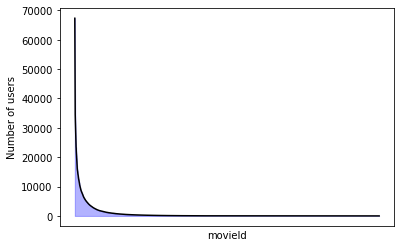

In [43]:
print(volume_df.iloc[int(len(volume_df)*0.1):int(len(volume_df)*0.1)+3, :])
x=range(0,len(volume_df))
ax = sns.lineplot(x, y='volume', data=volume_df, color="black")
ax.set_ylabel('Number of users')
ax.set_xlabel(item_id_column)
x1 = volume_df[item_id_column]
y1 = volume_df['volume']
ax.fill_between(x1, y1, color="blue", alpha=0.3)
plt.xticks([], [])
ax.set(xticklabels=[])
plt.show()

Исключим все фильмы, у которых оценком меньше, чем 1306, тогда у нас останется примерно 86% исходных данных

In [8]:
data_large = data_large[~data_large['movieId'].isin(set(volume_df[volume_df['volume' ] < 1306]['movieId'].astype(int)))]

In [9]:
del df
del volume_df

# Выбор метрики
На одном стуле у нас квадратичные методы измерения ошибки, а на другом абсолютные, на какой пользователя посадим?
Ясно, что квадратичные методы будут увеличивать нам ошибку за счёт квадратов, т.е. штраф за большие ошибки будет ещё больше, значит мы будем улучшать точность с помощью этой метрики, в то время как абсолютный метод даст нам среднее улучшение по всем предсказаниям. Если наша задача выбрать один фильм да такой, чтоб пользователь плакал от удовольствия, то логичнее будет использовать квадратичный метод - RMSE

# Подбор разбиения данных на train, valid, test
Для начала нужно разделить данные на train и test, а потому уже на CV мы будем пилить train ещё и на valid.

Есть несколько подходов к разделению: 
1. Leave One Last 
*   Leave One Last Item
Удаляем последний item для юзера, чтобы дальше использовать на тесте. Возможен leak, не подойдёт для оценки гибридных алгоритмов, так как в будущем мы будем использовать информацию о предметах, что может также привести к leak-у
*   Leave One Last Basket/Session
Удаляем одну сессию у юзера, обычно используется для продуктовых корзин и пр. Нам не подойдёт

2. Temporal User/Global Split (метод, основанный на разделении данных по времени)
* Temporal User 
Удаляем долю последних item-ов юзера, в нашем случае последних просмотренных фильмов

* Temporal Global
Так как время одинаково для всех, то мы относительно определённой даты и времени разделяем выборку, возможно самый реалистичный вариант. Но возможно такое разбиение, после которого юзера не окажется в данных train-а 
3. Random Split
Не будем использовать этот метод, так как он плохо воспроизводим и кажется, что разбиение относительно времени будет более реалистичным для данного датасета
4. User Split
Деление по юзерам, берём одно множество юзеров для трейна, а другое, не пересекающееся с первым, для теста. Нам не подойдёт, так как нужно использовать алгоритмы рассчитаные на холодный старт. 



## Проверяем возможность разбиения Temporal Global

In [ ]:
large_sorted = data_large.sort_values('timestamp')

In [ ]:
train_percent = 0.7
train_index = int(len(large_sorted)*train_percent)

In [ ]:
X_test = large_sorted.iloc[:train_index, :]
X_train = large_sorted.iloc[train_index:, :]
print(np.sort(X_test['userId'].unique()), '\n', np.sort(X_train['userId'].unique()))
set_test = set(X_test['userId'].unique())
set_train = set(X_train['userId'].unique())
print('-'*100)
print('Количество юзеров в трейне: ', len(X_train['userId'].unique()))
print('Количество юзеров в тестовой выборке: ', len(X_test['userId'].unique()))
print('Количество юзеоров, которых нет в тестовой выборке: ', len(set_train - set_test))
print('Количество юзеров количество юзеров в пересечении тестовой и трейновой выборки: ', len(set_train & set_test))

[     1      2      3 ... 138488 138490 138492] 
 [    11     14     18 ... 138489 138491 138493]
----------------------------------------------------------------------------------------------------
Количество юзеров в трейне:  45254
Количество юзеров в тестовой выборке:  98400
Количество юзеоров, которых нет в тестовой выборке:  40093
Количество юзеров количество юзеров в пересечении тестовой и трейновой выборки:  5161


Выборки получаются довольно несбалансированные, фактически нам нужно будет использовать алгоритмы рассчитанные на холодный старт, чтобы пользоваться таким разбиением

# Сделаем разбиение Temporal User 
Так как предыдущее разбиение нам не подошло, то будем разбивать выборку относительно времени по юзерам

In [10]:
film_train_percent = 0.7
X_train = pd.DataFrame()
X_test = pd.DataFrame()

In [11]:
def fnc(x):
    l = len(x)
    pivot = int(l*film_train_percent)
    return [True,]*pivot + [False,]*(l-pivot)

In [12]:
tmp = data_large.sort_values(['userId','timestamp']).groupby('userId')['timestamp']
large_sorted = data_large.assign(is_train=tmp.transform(fnc))

In [13]:
X_train = large_sorted[large_sorted['is_train']]
X_test = large_sorted[~(large_sorted['is_train'])]

X_train = X_train.drop(columns=['timestamp', 'is_train'])
X_test = X_test.drop(columns=['timestamp', 'is_train'])

In [14]:
del tmp
del large_sorted

In [ ]:
# Это лучше никогда не трогать
# large_sorted = data_large.set_index('userId')
# large_sorted = large_sorted[['timestamp', 'movieId', 'rating']]
# large_sorted = large_sorted.sort_values(['userId','timestamp'])
# for i in set(large_sorted.index):
#   userById = large_sorted.loc[i, :]
#   X_train = X_train.append(userById.iloc[:int(userById.shape[0]*film_train_percent)])
#   X_test = X_test.append(userById.iloc[int(userById.shape[0]*film_train_percent):])

И для small датасета

In [ ]:
film_train_percent = 0.7
small_train = pd.DataFrame()
small_test = pd.DataFrame()
small_sorted = data_small.sort_values('timestamp')

In [ ]:
for i in small_sorted['userId'].unique():
  user_id_data = small_sorted[small_sorted['userId'] == i]
  user_id_data.sort_values('timestamp')
  film_cnt = len(user_id_data)
  pivot = 1 if film_cnt == 1 else int(film_cnt*film_train_percent)
  small_train = small_train.append(user_id_data.iloc[:pivot, :])
  small_test = small_test.append(user_id_data.iloc[pivot:, :])

Также попробуем случайное разбиение 


In [ ]:
random_train, random_test, Yrandom_train, Yrandom_test = train_test_split(data_small, data_small['userId'], test_size = 0.3, stratify=data_small['userId'], shuffle=True)

# Сделаем стандартизацию данных 
Так как далее будет использован алгоритм коллабаративной фильтрации(CF) на основе kNN, то нужно бы превести данные к нормальному распределению 

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_small = StandardScaler()
scaler_small.fit(np.array(small_train['rating']).reshape(-1, 1))

scaler_random = StandardScaler()
scaler_random.fit(np.array(random_train['rating']).reshape(-1, 1))

StandardScaler()

In [15]:
from sklearn.preprocessing import StandardScaler

scaler_large = StandardScaler()
scaler_large.fit(np.array(X_train['rating']).reshape(-1, 1))

StandardScaler()

In [16]:
transformed_large_train = scaler_large.transform(np.array(X_train['rating']).reshape(-1, 1))
transformed_large_test = scaler_large.transform(np.array(X_test['rating']).reshape(-1, 1))

In [ ]:
transformed_small_train = scaler_small.transform(np.array(small_train['rating']).reshape(-1, 1))
transformed_random_train = scaler_random.transform(np.array(random_train['rating']).reshape(-1, 1))

transformed_small_test= scaler_small.transform(np.array(small_test['rating']).reshape(-1, 1))
transformed_random_test = scaler_random.transform(np.array(random_test['rating']).reshape(-1, 1))

# SVD, kNN, CoClustering FC 
С датасетом TemporalUser small

In [ ]:
from surprise.accuracy import rmse

In [ ]:
X = small_train.copy()
X['rating'] = transformed_small_train
ratings = X.drop(columns='timestamp')

y = small_test.copy()
y['rating'] = transformed_small_test
y = y.drop(columns='timestamp')

reader = Reader(line_format='user item rating', rating_scale=(-4,2))
formed_ratings = Dataset.load_from_df(ratings, reader)
train = formed_ratings.build_full_trainset()

reader = Reader(line_format='user item rating', rating_scale=(-4,2))
test = Dataset.load_from_df(y, reader)
test = test.build_full_trainset()
test = test.build_testset()

In [ ]:
baseline = BaselineOnly()
kNN = KNNBasic()
svd = SVD(n_factors=50, n_epochs=30)
coCluster = CoClustering()

baseline.fit(train)
kNN.fit(train)
svd.fit(train)
coCluster.fit(train)

print(rmse(baseline.test(test)), rmse(kNN.test(test)), rmse(svd.test(test)),
      rmse(coCluster.test(test)))

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8624
RMSE: 0.9220
RMSE: 0.8636
RMSE: 0.8992
0.8624493633156017 0.9219662386833217 0.863641580877668 0.8991795061607294


In [ ]:
baseline = BaselineOnly()
kNN = KNNBasic()
svd = SVD(n_factors=50, n_epochs=30)
coCluster = CoClustering()

# Попробуем сделать просто кросс-валидацию

print(cross_validate(baseline, formed_ratings, measures=['RMSE'], cv = 2, verbose=True))
print(cross_validate(kNN, formed_ratings, measures=['RMSE'], cv = 2, verbose=True))
print(cross_validate(svd, formed_ratings, measures=['RMSE'], cv = 2, verbose=True))
print(cross_validate(coCluster, formed_ratings, measures=['RMSE'], cv = 2, verbose=True))

Estimating biases using als...
Estimating biases using als...
Evaluating RMSE of algorithm BaselineOnly on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.8559  0.8583  0.8571  0.0012  
Fit time          0.12    0.12    0.12    0.00    
Test time         0.16    0.15    0.15    0.00    
{'test_rmse': array([0.85591937, 0.85834612]), 'fit_time': (0.11705565452575684, 0.12269306182861328), 'test_time': (0.15674281120300293, 0.1487877368927002)}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.9221  0.9262  0.9241  0.0021  
Fit time          0.05    0.06    0.06    0.00    
Test time         1.56    1.51    1.54    0.02    
{'test_rmse': array([0.92208454, 0.92620759]), 'fit_time': (0.05414438247680664, 0.06017732620239258), 'test_time

# Implicit-ALS


In [ ]:
!pip install nmslib

     |████████████████████████████████| 13.5 MB 5.5 MB/s 
     |████████████████████████████████| 188 kB 50.2 MB/s 


In [ ]:
import scipy.sparse as sparse
import implicit
from implicit.als import AlternatingLeastSquares
from sklearn.metrics import mean_squared_error

sparse_user_item_FILMS = sparse.csr_matrix((X['rating'].astype(float), (X['userId'], X['movieId'])))
ALS = AlternatingLeastSquares(factors=10, regularization=0.1, iterations=20, random_state=42)

alpha_val = 19
data_conf = (sparse_user_item_FILMS * alpha_val).astype('double')

In [ ]:
ALS.fit(data_conf)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
ALS_MATR = np.matmul(ALS.user_factors, ALS.item_factors.T)
test = y.copy()
test.insert(loc=2, column='predRatin', value=0.0)

for i in range(len(test)):
  test.iloc[i, 2] = ALS_MATR[test.iloc[i, 0].astype('int'), test.iloc[i, 1].astype('int')]

In [ ]:
print('RMSE:', np.sqrt(mean_squared_error(test['rating'], test['predRatin'])))

RMSE: 0.9954158051875825


# LightFM


In [ ]:
!pip install lightfm

from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

     |████████████████████████████████| 310 kB 5.0 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705356 sha256=b6996cd7e73aa226e4bc1b50d56c5a39e9315db81e12fba8f8179ea40119a92d
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm


## Подгрузим данные и обработаем их

In [ ]:
movie_for_ind = pd.read_csv('Mini_dataset/movies.csv')
indexes = movie_for_ind['movieId']
movie = pd.read_csv('Mini_dataset/movies.csv', index_col = 'movieId')
movie['year'] = movie['title'].str.extract('.*\((.*)\).*',expand = False)

genres = set()
for s in movie['genres'].str.split('|').values:
    genres = genres.union(set(s))

for i in genres:
  movie.insert(3, column=i, value=0)

In [ ]:
for i in indexes:
  for g in movie.loc[i, 'genres'].split('|'):
    movie.loc[i, str(g)] = 1
movie = movie.drop(columns=['title', 'genres', 'year'])

In [ ]:
df_cols = movie.columns

In [ ]:
dict_ganres = { value: i for i, value in enumerate(df_cols) }

In [ ]:
g_df = pd.DataFrame(columns=['movieId', 'genreId', 'interaction'])

for id, value in movie.iterrows():
  for k, i in enumerate(value):
    if i != 0:
      g_df = g_df.append({'movieId':id ,'genreId':k ,'interaction':i}, ignore_index=True)
g_df 

,movieId,genreId,interaction
0,1,6,1
1,1,8,1
2,1,12,1
3,1,17,1
4,1,19,1
...,...,...,...
22079,193583,19,1
22080,193585,5,1
22081,193587,10,1
22082,193587,12,1


In [ ]:
csr_movie = sparse.csr_matrix((g_df['interaction'].astype(float), (g_df['movieId'], g_df['genreId'])))

Обучим модель

In [ ]:
model = LightFM(learning_rate=0.05, loss='warp')
model.fit(sparse_user_item_FILMS,
          user_features=None,
          item_features=csr_movie,
          epochs=20)

In [ ]:
predictions = model.predict(user_ids=y['userId'].values, item_ids=y['movieId'].values, item_features=csr_movie)
print(np.sqrt(mean_squared_error(predictions, y['rating'].values)))

1.8860326700072703


# Тренировка лучшего алгоритма на large_dataset-е
Исходя из тестов на small_dataset-е лучшим алгоритмом оказался SVD-CF.

Далее обучим этот алгоритм на large_dataset-е и подберём оптимальные гиперпараметры.

In [17]:
from surprise.model_selection.search import GridSearchCV
from surprise import SVD, Reader, Dataset
import gc


In [19]:
X = X_train.copy()
X['rating'] = transformed_large_train

y = X_test.copy()
y['rating'] = transformed_large_test


reader = Reader(line_format='user item rating', rating_scale=(-4,2))
formed_ratings = Dataset.load_from_df(X, reader)
train = formed_ratings.build_full_trainset()

In [ ]:
reader = Reader(line_format='user item rating', rating_scale=(-4,2))
test = Dataset.load_from_df(y, reader)
test = test.build_full_trainset()
test = test.build_testset()

In [20]:
svd = SVD
param_dict = {'n_factors':[10, 20], 'n_epochs': [15, 30], 'lr_all':[0.001, 0.01, 0.05], 'random_state':[42]}
GridSearch = GridSearchCV(svd, param_grid = param_dict, measures=['rmse', 'mae'], n_jobs=-1)
GridSearch.fit(formed_ratings)

In [21]:
gc.collect()
svd_1 = SVD(n_factors=10, n_epochs=10, lr_all=0.01)

In [22]:
svd_1.fit(train)

In [26]:
from surprise.accuracy import rmse
print(rmse(svd_1.test(test)))

RMSE: 0.7808
0.78077386393886


In [27]:
del svd_1

In [29]:
gc.collect()

521

In [30]:
svd = SVD(n_factors=5, n_epochs=5, lr_all=0.1)

In [31]:
svd.fit(train)

In [32]:
print(rmse(svd.test(test)))

RMSE: 0.8948
0.8948374857232102
